[Lukas Vasquez Verdejo y Ken Miyake M.]

En esta tarea van a crear una red neuronal que clasifique mensajes como spam o no spam. Lo primero es descargar la data:

In [ ]:
!wget https://www.ivan-sipiran.com/downloads/spam.csv

--2022-12-05 21:08:13--  https://www.ivan-sipiran.com/downloads/spam.csv
Resolving www.ivan-sipiran.com (www.ivan-sipiran.com)... 66.96.149.31
Connecting to www.ivan-sipiran.com (www.ivan-sipiran.com)|66.96.149.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 471781 (461K)
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 460.72K   627KB/s    in 0.7s    

2022-12-05 21:08:15 (627 KB/s) - ‘spam.csv’ saved [471781/471781]



Los datos vienen en un archivo CSV que contiene dos columnas "text" y "label". La columna "text" contiene el texto del mensaje y la columna "label" contiene las etiquetas "ham" y "spam". Un mensaje "ham" es un mensaje que no se considera spam.

# Tarea
El objetivo de la tarea es crear una red neuronal que clasifique los datos entregados. Para lograr esto debes:



*   Implementar el pre-procesamiento de los datos que creas necesario.
*   Particionar los datos en 70% entrenamiento, 10% validación y 20% test.
*   Usa los datos de entrenamiento y valiadación para tus experimentos y sólo usa el conjunto de test para reportar el resultado final.

Para el diseño de la red neuronal puedes usar una red neuronal recurrente o una red basada en transformers. El objetivo de la tarea no es obtener el performance ultra máximo, sino entender qué decisiones de diseño afectan la solución de un problema como este. Lo que si es necesario (como siempre) es que discutas los resultados y decisiones realizadas.



# Introducción

En el presente informe se trabajará con un dataset de correos electrónicos los cuales poseen dos clases: ham y spam. Se intentará clasificar los correos  mediante  el uso  de modelos  de redes neuronales, en particular, RNN y Transformers.

## Descripción de Data-Set

El Data Set  a utilizar consta de 5572 filas  correspondientes a spam (746) , ham (4617) los cuales se encuentran correctamente etiquetados. El resto de las filas del dataset son corruptas, por ejemplo, columnas en la etiqueta que contienen  basura o textos que corresponden a strings vacíos.


 ### Carga de Datos


In [ ]:
import pandas as pd
#Primero se cargan todos los datos  del csv
data=pd.read_csv('spam.csv')
text=data['text']
labels=data['label']
#Copia de los datos con los que trabajará BERT
original_text=data['text']
original_labels=data['label']
print('Cantidad de mensajes:' ,len(text))


Cantidad de mensajes: 5572


### Pre-Procesamiento

Necesitamos separar los mensajes de los labels.Para esto el procedimiento es el siguiente:
<ul>
<li>Eliminamos los signos de puntuación en los textos.
<li> Dejamos strings en minúsculas


In [ ]:
from string import punctuation

text=text.astype(str).apply(lambda x: x.lower())
text_dep=text.astype(str).apply(lambda x: ''.join([c for c in x if c not in punctuation]))
print(punctuation)
print(text_dep[0])


!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat


Generamos un diccionario con  cada palabra  en los emails, esto nos servirá para  posteriormente pasarlos como paramteros a nuestra red neuronal.

In [ ]:
from collections import Counter

words=''.join(text_dep.astype(str).apply(lambda x: x+' ')).split() #juntamos todas las filas en un string  agregamos un espacio al final para el split
counts = Counter(words) #Construye un diccionario de palabras. Las claves son las palabras y los valores son la frecuencia
vocab = sorted(counts, key=counts.get, reverse=True) #Ordenamos la palabras por frecuencia
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)} #Construimos diccionario para mapear palabra a número entero. Empezamos los índices en 1

#Ahora convertimos cada palabra de los reviews en índices
encoded_text = []
for mail in text_dep.tolist():
  encoded_text.append([vocab_to_int[word] for word in mail.split()])

#Palabras en el dict
print('Palabras únicas:', len(vocab_to_int))

Palabras únicas: 9396


Realizamos la codificación para cada palabra en labels.Si es spam entonces se deja con 1, si no 0.

In [ ]:
import numpy as np

labels_list = labels.tolist()
encoded_labels = np.array([1 if label == 'spam' else 0 if label=='ham' else 2  for label in labels_list])
print('spam ', sum(encoded_labels==1))
print('ham ', sum(encoded_labels==0))
print('garbage label', sum(encoded_labels==2))

print('spam + ham',sum(encoded_labels==1)+sum(encoded_labels==0))

spam  746
ham  4617
garbage label 209
spam + ham 5363


Realizamos un conteo del largo asociado a cada mail.Podemos apreciar la distribución de estos datos

Mensajes de longitud cero: 2
Máxima longitud: 171


Text(0, 0.5, 'Amount')

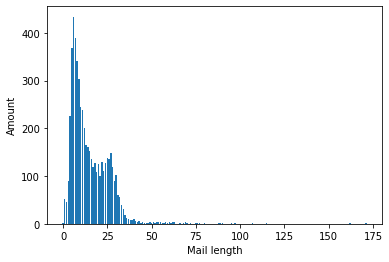

In [ ]:
import matplotlib.pyplot as plt
text_lens= Counter([len(x) for x in encoded_text]) #Contamos cuantas palabras hay en cada review
print("Mensajes de longitud cero:", text_lens[0])
print('Máxima longitud:', max(text_lens))

x= [i for i in range(0,172)]
y= [text_lens[i] for i in range(0,172)]


fig ,ax =plt.subplots()
ax.bar(x,y)
ax.set_xlabel('Mail length')
ax.set_ylabel('Amount')


Eliminamos los textos de largo 0 y los textos con labels basura.

In [ ]:
print('Mensajes antes de eliminación:', len(encoded_text))

#Extraemos los índices de todos los reviews que tienen longitud > 0
non_zero_idx = [ii for ii, text in enumerate(encoded_text) if len(text)!=0]
#Extraemos los indices de los mensajes mal etiquetados
non_zero_idx = [ii for ii in non_zero_idx if encoded_labels[ii] !=2]

#Nos quedamos solo con los reviews con longitud > 0
encoded_nz_texts = [encoded_text[ii] for ii in non_zero_idx]

#Lo mismo con los labels
encoded_nz_labels = np.array([encoded_labels[ii] for ii in non_zero_idx])


print('Reviews después de eliminación (zeros and garbage label):', len(encoded_nz_labels))

Mensajes antes de eliminación: 5572
Reviews después de eliminación (zeros and garbage label): 5361


Dejamos un largo fijo para  los mensajes , esto para uniformizar la entrada  de los inputs y poder computarlos en batches.

Definimos el largo para las sequencias.Los mensajes con un largo menor se completan con 0's al inicio de la secuencia.Si tienen un largo mayor, simplemente se truncan.

In [ ]:
def pad_features(encoded_nz_text, seq_length):
  features = np.zeros((len(encoded_nz_text), seq_length), dtype=int)

  #Para cada review, se coloca en la matriz
  for i, row in enumerate(encoded_nz_text):
    features[i, -len(row):] = np.array(row)[:seq_length]

  return features

### Partición de Datos

Procedemos a separar los datos en en train (70%), validation (10%)  y test (20%).

In [ ]:
#Probamos el padding
seq_length = 171

features = pad_features(encoded_nz_texts, seq_length=seq_length)

print(features.shape)


(5361, 171)


In [ ]:
split_frac = 0.7

## split data into training, validation, and test data (features and labels, x and y)
split_idx = int(len(features)*split_frac)
train_x, remaining_x = features[:split_idx], features[split_idx:]
train_y, remaining_y = encoded_nz_labels[:split_idx], encoded_nz_labels[split_idx:]

test_idx = int(len(remaining_x)*0.33)


val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

## print out the shapes of your resultant feature data
print("\t\t\tFeatures:")
print("Train set: \t\t{}".format(train_x.shape),
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Features:
Train set: 		(3752, 171) 
Validation set: 	(530, 171) 
Test set: 		(1079, 171)


### Data Loaders


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# crear Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# dataloaders
batch_size = 40

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size,  drop_last=True)

In [ ]:
# Chequear si tenemos GPU
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

No GPU available, training on CPU.


# Experimentos

### Descripción de modelos
Para abordar este problema se hará uso  principalmente de  dos redes LSTM (y bidirectional LSTM) y BERT en 3 experimentos.
La LSTM (long short term memory) es un tipo de red neuronal recurrente  que surge como solución al problema de  “vanishing - gradients” o “exploding- gradients”.La  idea principal de LSTM es  que posee  2 vías de aprendizaje  para secuencias , la puerta de entrada de los estados ocultos de una red recurrente convencional (corto plazo) y una memoria  dada por una función de “forgetting” (largo plazo) . La presencia de esta memoria largo plazo actúa como un bypass  entre las capas finales con las iniciales  evitando  la exploción en la retropropagación de errores.

## Experimento 1: LSTM

Para este experimento se entrenará una red LSTM normal limitando el largo de la secuencia a 170 (mail de largo máximo).


## Modelo

In [ ]:
#Creamos la red neuronal
import torch.nn as nn

class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5,bidirectional=False):

        super(SentimentRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        # Capas embedding y LSTM
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                            dropout=drop_prob, batch_first=True,bidirectional=bidirectional)
        num_directions = 2 if bidirectional else 1
        # dropout
        self.dropout = nn.Dropout(drop_prob)

        # Capa lineal y sigmoide
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()

    def forward(self, x, hidden):

        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)

        #Tomamos solo el último valor de salida del LSTM
        lstm_out = lstm_out[:,-1,:]

        # dropout y fully-connected
        out = self.dropout(lstm_out)
        out = self.fc(out)

        # sigmoide
        sig_out = self.sig(out)

        # retornar sigmoide y último estado oculto
        return sig_out, hidden


    def init_hidden(self, batch_size):
        # Crea dos nuevos tensores con tamaño n_layers x batch_size x hidden_dim,
        # inicializados a cero, para estado oculto y memoria de LSTM
        weight = next(self.parameters()).data

        if(train_on_gpu):
          hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                   weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
          hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                   weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())

        return hidden

In [ ]:
# Instanciamos la red
vocab_size = len(vocab_to_int) + 1 # +1 for zero padding + our word tokens
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 2

net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net)

SentimentRNN(
  (embedding): Embedding(9397, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


### Entrenamiento

In [ ]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [ ]:
# training params

epochs = 4

counter = 0
print_every = 100
clip=5 # gradient clipping

# Enviar red al GPU
if(train_on_gpu):
    net.cuda()

net.train()
# Bucle de entrenamiento
for e in range(epochs):
    # Inicializar estado oculto
    h = net.init_hidden(batch_size)

    # Bucle para batchs
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # Crear nuevas variables para estados ocultos, sino se haría
        # backprop para todos los pasos del bucle
        h = tuple([each.data for each in h])

        net.zero_grad()

        # Hacer pasada forward
        output, h = net(inputs, h)

        # Calcular loss y hacer backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # gradient clipping
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # Mensajes
        if counter % print_every == 0:
            # Validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:

                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

            net.train()
            print("Época: {}/{}...".format(e+1, epochs),
                  "Paso: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

Época: 2/4... Paso: 100... Loss: 0.000138... Val Loss: 0.078054
Época: 3/4... Paso: 200... Loss: 0.005729... Val Loss: 0.125734
Época: 4/4... Paso: 300... Loss: 0.000202... Val Loss: 0.100389


### Calculamos el Test Accuracy
En el siguiente apartado se calcula el accuracy. También se calculará el accuracy especifico a cada clase (fracción  de predicciones correctas para spam y para  ham) para dilucidar de mejor manera el desempeño del modelo.

In [ ]:
# Calcular accuracy de test

test_losses = [] # track loss
num_correct = 0
spam_correct=0
spam=0
ham=0
ham_correct=0
# Iniciar estado oculto
h = net.init_hidden(batch_size)

net.eval()
for inputs, labels in test_loader:

    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()

    output, h = net(inputs, h)

    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())

    # Convertir probabilidades a clases (0,1)
    pred = torch.round(output.squeeze())

    # Comparar predicciones a labels
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)
    pred_np=pred.detach().cpu().numpy()
    label_np=labels.float().detach().cpu().numpy()

    spam_mask=[label_np==1]
    ham_mask=[label_np==0]
    spam+=label_np.tolist().count(1)
    ham+=label_np.tolist().count(0)

    spam_correct+=pred_np[spam_mask].tolist().count(1)
    ham_correct+=pred_np[ham_mask].tolist().count(0)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# Accuracy de test
test_acc = num_correct/len(test_loader.dataset)
print("Ham Acc: {:.3f}".format(ham_correct/ham))
print("Spam Acc: {:.3f}".format(spam_correct/spam))
print("Test accuracy: {:.3f}".format(test_acc))

<ipython-input-19-36ad9fcfbe6c>:40: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  spam_correct+=pred_np[spam_mask].tolist().count(1)
<ipython-input-19-36ad9fcfbe6c>:41: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ham_correct+=pred_np[ham_mask].tolist().count(0)


Test loss: 0.107
Ham Acc: 0.997
Spam Acc: 0.901
Test accuracy: 0.948


Se puede observar el modelo  presenta  un menor performance cuando lo utilizamos para identificar spam.Esto puede deberse a la  gran cantidad de "ham" presentes en el dataloader del entrenamiento en comparación a  los "spam".En los ejemplos siguientes (inferencias)  se muestra que el modelo no es robusto  en la identificación  de algunos "spam".

## Inferencia
Es posible igrsar inputs para probar el modelo

In [ ]:
from string import punctuation

def tokenize_review(test_mail):
    test_mail = test_mail.lower()
    test_text = ''.join([c for c in test_mail if c not in punctuation])
    test_words = test_text.split()
    test_ints = []
    test_ints.append([vocab_to_int[word] for word in test_words if word in vocab_to_int])#alterado
    print('palabras desconocidas :',[x for x in test_words if x not in vocab_to_int])
    return test_ints

In [ ]:
def predict(net, test_review, sequence_length=200):

    net.eval()

    test_ints = tokenize_review(test_review)

    seq_length = sequence_length
    features = pad_features(test_ints, seq_length)

    feature_tensor = torch.from_numpy(features)

    batch_size = feature_tensor.size(0)

    h = net.init_hidden(batch_size)

    if(train_on_gpu):
      feature_tensor = feature_tensor.cuda()

    output, h = net(feature_tensor, h)

    pred = torch.round(output.squeeze())
    print('Valor predicho, antes del redondeo: {:.6f}'.format(output.item()))

    # print custom response based on whether test_review is pos/neg
    if(pred.item()==1):
      print('spam')
    else:
      print('ham ')

Ejemplo 1:

In [ ]:
seq_length=40
text="""Are you ready to lead sustainable change in your community? The final deadline for Boston University’s online Master of Public Health from its top-ranked School of Public Health is almost here.*

Apply by Nov. 1 for the Spring 2023 cohort.
No GRE scores are required to apply.."""

predict(net,text, len(text.split()))


47
palabras desconocidas : ['sustainable', 'deadline', 'university’s', 'master', 'health', 'topranked', 'health', 'nov', '2023', 'cohort']
Valor predicho, antes del redondeo: 0.684975
spam


Ejemplo 2:

In [ ]:
seq_length=40
text="""
Ready to maximize your workflow? Saving time with stock 3D is great, and saving money is
even better. Take up to 50% off a massive selection of our 3D model catalog during our Flash Sale!"""

predict(net,text, len(text.split()))

35
palabras desconocidas : ['workflow', 'saving', 'saving', 'catalog']
Valor predicho, antes del redondeo: 0.000091
ham 


# Experimento 2: Transformer BERT (Bidirectional Encoder Representations from Transformers)

Si bien el uso de LSTM para el problema parece ser suficiente para obtener resultados satisfactorios, se experimentará con BERT dado que es parte de la familia de modelos que forman parte del estado del arte en lo que a NLP se refiere, por lo que esperamos que los resultados sean superiores a los obtenidos hasta ahora. El pipeline usado se obtuvo del [documento](https://colab.research.google.com/drive/1Y4o3jh3ZH70tl6mCd76vz_IxX23biCPP), en particular, ser realizará fine-tuning con BERT mediante el uso de la libreria Pytorch de HuggingFace

In [ ]:
#En esta celda se intentará usar la GPU, en caso de que no se pueda se usará la CPU
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 12.2 MB/s 
     |███████████████████████         | 5.5 MB 5.9 MB/s eta 0:00:01

Descargamos el tokenizador de BERT, nos permitirá "tokenizar" el texto del dataset y dejar los datos con el formato con el cual BERT podrá procesarlos.

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
print(original_text[0])

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


**Pre-procesamiento de los datos** \\
Aquí pre-procesaremos los datos. Se eliminarán filas con datos nulos y/o que contengan basura (algunos labels contienen datos basura)

In [ ]:
datos_texto=[]
datos_labels=[]

for i, sentence in enumerate(original_text):
  if (type(sentence)== type("text")) and (len(sentence)>0) and ((original_labels[i]=="spam") or (original_labels[i]=="ham")):
    datos_texto.append(sentence)
    datos_labels.append(original_labels[i])





In [ ]:
count_spam=0
count_ham=0
for i, etiqueta in enumerate(datos_labels):
  if(etiqueta=="spam"):
    datos_labels[i]=1
    count_spam+=1
  else:
    datos_labels[i]=0
    count_ham+=1

Revisamos con cuantos datos nos quedamos:

1.   Spam= 746
2.   Ham= 4617
3. Total= 5363

In [ ]:
print(count_spam)

746


In [ ]:
print(count_ham)
print(len(datos_labels))

4617
5363


In [ ]:
#Esta casilla contiene un ejemlpo de basura en la columna original de labels
print(original_labels[3035])

-) ok. I feel like john lennon.


A continuación se procesarán los datos para dejarlos en el formato adecuado para que BERT pueda trabajar con ellos, en particular:

1. Cada "correo" debe comenzar y terminar con los tokens especiales [CLS] y [SEP], respectivamente.
2. Se le aplicará padding a cada uno de los correos, su simbolo especial es [PAD] y su id es 0
3. La función "encode" realiza el trabajo de tokenizar el texto y convertir cada token del correo a su id (Dichas ID's son fueron asignadas previamente)

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in datos_texto:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', datos_texto[0])
print('Token IDs:', input_ids[0])

Original:  Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Token IDs: [101, 2175, 2127, 18414, 17583, 2391, 1010, 4689, 1012, 1012, 2800, 2069, 1999, 11829, 2483, 1050, 2307, 2088, 2474, 1041, 28305, 1012, 1012, 1012, 25022, 2638, 2045, 2288, 26297, 28194, 1012, 1012, 1012, 102]


In [ ]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  221


Elegimos como tamaño de cada dato al largo del correo más grande, a los datos de menor tamaño se les aplicará padding

In [ ]:
# We'll borrow the `pad_sequences` utility function to do this.
from keras_preprocessing.sequence import pad_sequences
# Set the maximum sequence length.
# I've chosen 64 somewhat arbitrarily. It's slightly larger than the
# maximum training sentence length of 47...
MAX_LEN = 221

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long",
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 221 values...

Padding token: "[PAD]", ID: 0

Done.


In [ ]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:

    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]

    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

In [ ]:
from sklearn.model_selection import train_test_split


#Acá deberiamos hacer un doble split con train_test_split: Uno con train/test, el otro sobre train-> train/test
# Use 70% for training and 30% for validation.
train_inputs, test_inputs, train_labels, test_labels = train_test_split(input_ids, datos_labels,
                                                            random_state=2018, test_size=0.3)


train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, datos_labels,
                                                            random_state=2018, test_size=0.125)

# Do the same for the masks.
train_masks, test_masks, _, _ = train_test_split(attention_masks, datos_labels,
                                             random_state=2018, test_size=0.3)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, datos_labels,
                                             random_state=2018, test_size=0.125)

In [ ]:
# Convert all inputs and labels into torch tensors, the required datatype
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
test_inputs = torch.tensor(test_inputs) #datos de test a tensores

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
test_labels = torch.tensor(test_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
test_masks = torch.tensor(test_masks)


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Create the DataLoader for our test set.
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

Descargamos BERT pre-entrenado y lo enviamos a la GPU

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Detalles y componentes del modelo:

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Entrenamiento y evaluación del modelo:

In [ ]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)

        # The call to `model` always returns a tuple, so we need to pull the
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    147.    Elapsed: 0:00:44.
  Batch    80  of    147.    Elapsed: 0:01:30.
  Batch   120  of    147.    Elapsed: 0:02:14.

  Average training loss: 0.12
  Training epcoh took: 0:02:44

Running Validation...
  Accuracy: 0.99
  Validation took: 0:00:09

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    147.    Elapsed: 0:00:45.
  Batch    80  of    147.    Elapsed: 0:01:30.
  Batch   120  of    147.    Elapsed: 0:02:15.

  Average training loss: 0.02
  Training epcoh took: 0:02:45

Running Validation...
  Accuracy: 0.99
  Validation took: 0:00:09

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    147.    Elapsed: 0:00:45.
  Batch    80  of    147.    Elapsed: 0:01:30.
  Batch   120  of    147.    Elapsed: 0:02:15.

  Average training loss: 0.01
  Training epcoh took: 0:02:45

Running Validation...
  Accuracy: 0.99
  Validation took: 0:00:09

======== Epoch 4 / 4 ========
Training...
  Batch    40  of 

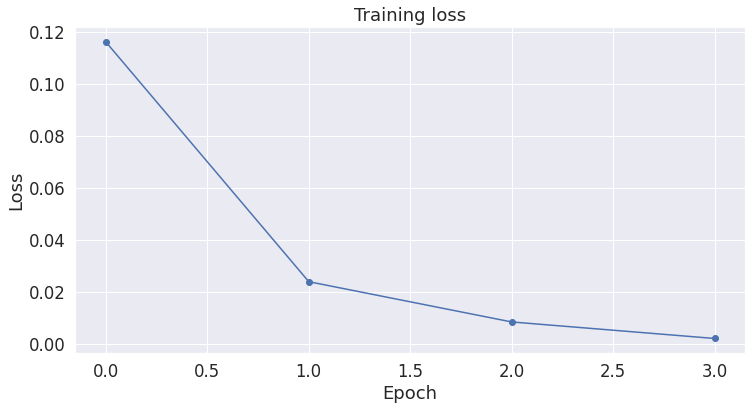

In [ ]:
import matplotlib.pyplot as plt
#matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

A partir de aquí se evaluará el modelo con el conjunto de test:

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 1,609 test sentences...
    DONE.


In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):

  # The predictions for this batch are a 2-column ndarray (one column for "0"
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  # Calculate and store the coef for this batch.
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


In [ ]:
matthews_set

[1.0,
 1.0,
 1.0,
 0.8509629433967631,
 1.0,
 1.0,
 0.8459051693633014,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.8027729719194864,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.8958064164776167,
 1.0,
 0.9229582069908973,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9165151389911681,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

La métrica que se usa aquí es ["Matthews correlation coefficient" (MCC)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html).

In [ ]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.984


In [ ]:
def predict_bert(net, test_review, sequence_length=200):

    net.eval()

    test_ints = tokenize_review(test_review)

    seq_length = sequence_length
    features = pad_features(test_ints, seq_length)

    feature_tensor = torch.from_numpy(features)

    batch_size = feature_tensor.size(0)

    h = net.init_hidden(batch_size)

    if(train_on_gpu):
      feature_tensor = feature_tensor.cuda()

    output, h = net(feature_tensor, h)

    pred = torch.round(output.squeeze())
    print('Valor predicho, antes del redondeo: {:.6f}'.format(output.item()))

    # print custom response based on whether test_review is pos/neg
    if(pred.item()==1):
      print('spam')
    else:
      print('ham ')

In [ ]:
seq_length=40
text="""
MAY 9–10
50% off
Whatever your coding goals may be, now’s a great time to commit to achieving them.
That’s why for the next two days, we’re offering 50% off annual memberships to Codecademy Pro. Just use promo code MAYSALE22 at checkout."""
print(len(text.split()))
predict(model,text, len(text.split()))

# Síntesis de resultados

| Modelo               |    Accuracy           |
|            ----------|:-------------:        |  
| BERT                 |  0.99                 |

| Modelo               |    Test Accuracy      | Spam Accuracy |Ham Accuracy|
|            ----------|:-------------:        |:-------------:| :-----------:|
| LSTM                 |     0.945              |  0.901     | 0.997            |  




#**Conclusión**
En el presente trabajo se experimentó con dos tipos de modelos, redes neuronales recurrentes y transformers. Se logró evidenciar que las LSTM pueden ser lo suficientemente poderosas como para poder crear modelos que puedan resolver problemas que no son necesariamente tan especializados o complejos, en particular, el problema de clasificar si un correo es spam o no.Dicho esto, se puede concluir que, pese a que los transformers son modelos muy poderosos, dependiendo del problema que se quiera resolver, puede resultar más práctico y eficiente el uso de modelos más simples, ya que , en primer, hacer fine-tuning de estos modelos puede tomar más tiempo que entrenar un modelo más simple, debido a la gran cantidad de parámetros que posee y además, resulta más tedioso el pre-procesar los datos para que, en este caso, poder entregar a BERT los datos en el formato correcto (el modelo utilizado en esta tarea requería que los datos estuvieran en un formato determinado y del uso de máscaras que le dijeran al modelo cuando se está leyendo padding y cuando no). Aun así, el hecho de haber utilizado modelos que son parte del estado del arte resulta ser una experiencia valiosa.